### DATA Augmentation
J. Cristiano

Resources:

https://gist.github.com/interactivetech/c2913317603b79c02ff49fa9824f1104

https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html#sphx-glr-auto-examples-transforms-plot-transforms-e2e-py





In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image, ImageDraw
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np



In [2]:


# #create the dataset

# transform = v2.Compose([
#     v2.CenterCrop(2048),
#     v2.Resize((512, 512)),
#     v2.ToTensor(),   #for tensor operations
#     v2.ToPILImage(),    #for visualization
#     v2.ConvertImageDtype(torch.float32),
#     # v2.Normalize(mean=mean, std=std),
#     v2.RandomHorizontalFlip(p=1),
#     v2.RandomPerspective(distortion_scale=0.5, p=0.5),
#     v2.GaussianBlur(7, sigma=(0.1, 2.0)) 
# ])
# dataset = CocoDetection(
#     root='./2024_annot/images',
#     annFile='./2024_annot/2024_annotations.json',
#     transform=transform
# )

In [3]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.datasets.coco import CocoDetection

def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [4]:
coco_root = './2024_annot/images'
coco_annFile = './2024_annot/2024_annotations.json'
standard_transform = transforms.v2.Compose([
    v2.CenterCrop(2048), 
    v2.Resize((512, 512)), 
    v2.ToImage()
    ])
vanilla_dataset = datasets.CocoDetection(root=coco_root, annFile=coco_annFile, transforms=standard_transform)
vanilla_dataset = datasets.wrap_dataset_for_transforms_v2(vanilla_dataset, target_keys=("boxes", "labels", "masks"))

idx = random.randint(0, len(vanilla_dataset) - 1)
image, target = vanilla_dataset[idx]


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [5]:
augmentations = transforms.v2.Compose([
    transforms.v2.RandomPerspective(distortion_scale=0.25, p=0.5),
    transforms.v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.v2.RandomHorizontalFlip(p=0.5),
    transforms.v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),

])

In [6]:
transformations = {
    "Random Perspective": transforms.v2.RandomPerspective(distortion_scale=0.5, p=1.0),
    "Random Affine": transforms.v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    "Random Horizontal Flip": transforms.v2.RandomHorizontalFlip(p=1.0),
    "Color Jitter": transforms.v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
}
# for name, transform in transformations.items():
#     # Apply the transformation to the original image
#     combined_mask = torch.max(target["masks"], dim=0)[0]
#     plot([image, combined_mask])
#     transformed_image, transformed_mask = transform(image, target)
#     transformed_mask = torch.max(transformed_mask["masks"], dim=0)[0]
#     # transformed_mask = transform(combined_mask.unsqueeze(0))
#     print(name)
#     plot([transformed_image,transformed_mask])

In [7]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch.nn as nn


preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
def custom_collate_fn(batch):
    # Unpack the batch - assuming each item is a (image, mask) tuple
    images, masks = zip(*batch)
    binary_mask_batch = []
    for mask in masks:
        binary = torch.max(mask["masks"], dim=0)[0]
        binary_mask_batch.append(binary)

    # print(images[0], masks[0])
    return images, masks
#TODO: Add Weights
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
vanilla_dataset.transforms = transforms.v2.Compose([standard_transform, augmentations])
dataloader = DataLoader(
    vanilla_dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=2,
    collate_fn=custom_collate_fn)
training_results = {
    "train_loss": [],
    "test_loss" : [],  
    "pocket_loss": [],
    "pocket_model": None,
}
for epoch in range(30):
    running_loss = 0.0
    for img, mask in dataloader:
        model.train()
        img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in img])
        img = img.permute(0, 3, 1, 2).float()
        result = model(img)
        combined_mask = torch.stack([torch.max(m["masks"], dim=0)[0] for m in mask])
        loss = criterion(result, combined_mask.long())
        running_loss += loss.item()
        # print(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # print(len(dataloader))
    training_results["train_loss"].append(running_loss/len(dataloader))
    print(f"Epoch {epoch} - Loss: {training_results['train_loss'][-1]}")



# plot([img, combined_mask])
# plot(result.squeeze().detach().cpu().numpy())


Epoch 0 - Loss: 0.3057042349267889
Epoch 1 - Loss: 0.14924474364077603
Epoch 2 - Loss: 0.13692750450637606
Epoch 3 - Loss: 0.12556347995996475
Epoch 4 - Loss: 0.11731868485609691
Epoch 5 - Loss: 0.1007142250460607
Epoch 6 - Loss: 0.10394447669386864
Epoch 7 - Loss: 0.08441801990071933
Epoch 8 - Loss: 0.08171950418640066
Epoch 9 - Loss: 0.07724064395383552
Epoch 10 - Loss: 0.08261509488026302
Epoch 11 - Loss: 0.08340753435536667
Epoch 12 - Loss: 0.0887731516526805
Epoch 13 - Loss: 0.08539536250410257
Epoch 14 - Loss: 0.08141216125201296
Epoch 15 - Loss: 0.07978861599608704
Epoch 16 - Loss: 0.07562794853691701
Epoch 17 - Loss: 0.07091203476819727
Epoch 18 - Loss: 0.08347159113596987
Epoch 19 - Loss: 0.09281190415775334
Epoch 20 - Loss: 0.10357547068485508
Epoch 21 - Loss: 0.0932878431070734
Epoch 22 - Loss: 0.08506497395811258
Epoch 23 - Loss: 0.07601882876069457
Epoch 24 - Loss: 0.06710188021814381
Epoch 25 - Loss: 0.06393303956698489
Epoch 26 - Loss: 0.059554241597652435
Epoch 27 - Los

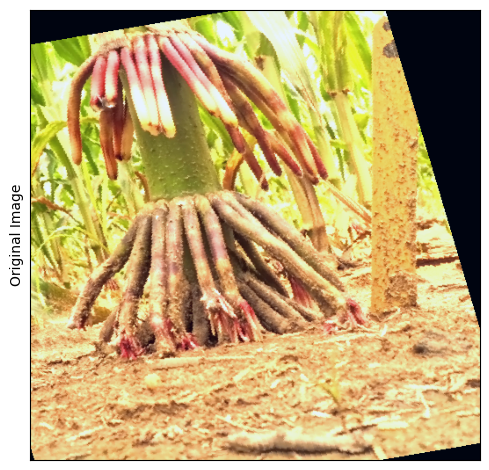

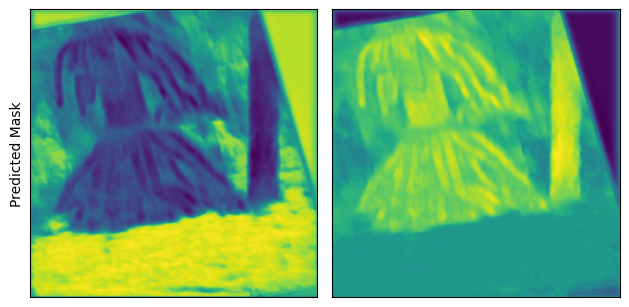

In [8]:
model.eval()
image, target = vanilla_dataset[idx]
image = torch.tensor(preprocess_input(image.permute(1, 2, 0).numpy()))
image = image.permute(2, 0, 1).unsqueeze(0).float()
result = model(image)
plot(image, row_title=["Original Image"])
plot(result.squeeze().detach().cpu().numpy(), row_title=["Predicted Mask"])